Follows steps in https://www.youtube.com/watch?v=sVcwVQRHIc8&t=2s

Part 1: https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_1_to_4.ipynb

In [1]:
import numpy as np
import pandas as pd
import tiktoken
from tiktoken._educational import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import bs4

In [293]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader, YoutubeLoader

In [5]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [7]:
from langchain_community.vectorstores import Chroma

In [8]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

In [9]:
## ChatPromptTemplate: Creates a chat template consisting of a single message assumed to be from the human (https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html)
from langchain.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

In [125]:
from langchain_core.prompts import PromptTemplate

In [10]:
from langchain_community.chat_models import ChatOllama

In [159]:
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

In [12]:
from langchain import hub

In [13]:
from langchain.load import dumps, loads

In [14]:
import langchain

In [15]:
from operator import itemgetter

In [322]:
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

In [157]:
from langchain.utils.math import cosine_similarity

In [255]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions

In [258]:
from langchain_core.messages import HumanMessage, SystemMessage

In [308]:
import datetime

## Get embeddings model (SentenceBERT) 

In [16]:
## Sentence BERT for sentence embeddings
# embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

## Get embeddings model (Nomic embddings)
## Original : https://blog.nomic.ai/posts/nomic-embed-text-v1, https://static.nomic.ai/reports/2024_Nomic_Embed_Text_Technical_Report.pdf
## https://huggingface.co/nomic-ai/nomic-embed-text-v1
## https://api.python.langchain.com/en/latest/embeddings/langchain_community.embeddings.huggingface.HuggingFaceBgeEmbeddings.html#langchain_community.embeddings.huggingface.HuggingFaceBgeEmbeddings

In [17]:
## nomic-embed-text-v1	is 8192 seq len embedder that is open source
model_name = "nomic-ai/nomic-embed-text-v1"
model_kwargs = {
    'device': 'cpu',
    'trust_remote_code':True
    }
encode_kwargs = {'normalize_embeddings': True}

In [18]:
embeddings = HuggingFaceBgeEmbeddings(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs, query_instruction="search_query:", embed_instruction="search_document:")

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [19]:
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [20]:
question_embedding = embeddings.embed_query(question)
document_embedding = embeddings.embed_query(document)
print(f"Dimensionality of question_embedding: {len(question_embedding)}")
print(f"Dimensionality of document_embedding: {len(document_embedding)}")

Dimensionality of question_embedding: 768
Dimensionality of document_embedding: 768


## Define similarity metric (cosine)

In [21]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product/(norm_vec1*norm_vec2)

In [22]:
sim = cosine_similarity(question_embedding, document_embedding)
print(f"Cosine Similarity between questiona dn document: {sim}")

Cosine Similarity between questiona dn document: 0.7388467122620958


## Get token count (as per BPE implemented in tiktoken library by OpenAI). Does not make sense for SentenceBert embedding 

In [23]:
def count_token_number(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens 

In [24]:
## cl100k_base is GPT-4 tokenizer
count_token_number(question, "cl100k_base")

8

## Visualize tokenization done by cl100k_base (GPT-4)

In [25]:
enc = SimpleBytePairEncoding.from_tiktoken("cl100k_base")
enc.encode(question)

What
What
What
What

 kinds
 kinds
 kinds
 kinds
 kinds
 kinds

 of
 of
 of

 pets
 pets
 pets
 pets
 pets

 do
 do
 do

 I
 I

 like
 like
 like
 like
 like

?



[3923, 13124, 315, 26159, 656, 358, 1093, 30]

## INDEXING (load, split and embed documents)

## 1. Load data from web page and use Beautifuloup to parse it

In [26]:
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

## 2. Split data using chunking strategies

In [27]:
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)

In [28]:
splits = splitter.split_documents(blog_docs)

In [29]:
print(f"Number of splits from blog_docs: {len(splits)} ")

Number of splits from blog_docs: 52 


## SPlits doc into splits. Each split has 300 tokens with overlap of 50 tokens 

In [30]:
content_length_list = [len(sp.page_content) for sp in splits]

<Axes: >

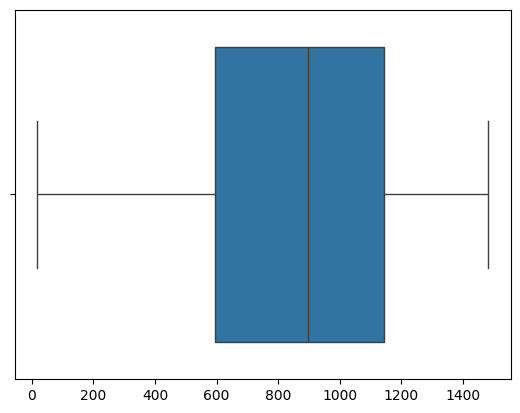

In [31]:
sns.boxplot(x=content_length_list)

In [32]:
## Metadata is the extra information around the doc that is split using recursive splitter
splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

In [33]:
! pwd

/Users/hardiksahi/Personal/rag/notebooks


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 3. Store embeddings to chromadb

In [44]:
## Initialize chroma db client
vectorstore = Chroma.from_documents(collection_name="rag_store_nomic", persist_directory="notebooks/chroma", documents=splits, embedding=embeddings)

In [45]:
vectorstore.get('043be940-5eb3-4ca9-ae66-6d07e094b493')#.keys()

{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

In [46]:
# vectorstore.delete_collection()

In [47]:
# retreiver = vectorstore.as_retriever(search_type="similarity", search_kwargs = {"k":4})

## This will prevent from getting unsure documents
retreiver = vectorstore.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.35}
)

In [48]:
relevant_docs = await retreiver.ainvoke("What is task decoposition?")

## These retreived splits are embedded into the context of LLM(GPT or LLama) as prompt to answer the query. 

## 4. Create prompt (https://api.python.langchain.com/en/latest/prompts/langchain_core.prompts.chat.ChatPromptTemplate.html#langchain_core.prompts.chat.ChatPromptTemplate)

In [49]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [50]:
print(prompt)

input_variables=['context', 'question'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'))]


In [51]:
print(type(prompt))

<class 'langchain_core.prompts.chat.ChatPromptTemplate'>


In [52]:
local_llm = ChatOllama(model="llama2:latest") ## num_predict

In [53]:
rag_chain = {"context":retreiver, "question": RunnablePassthrough()} | prompt | local_llm | StrOutputParser()

In [54]:
# chain = prompt | local_llm

# chain.invoke({"context":relevant_docs,"question":"What is Task Decomposition?"})

In [55]:
rag_chain.invoke("What is task decomposition?")

'Task decomposition is a process of breaking down a complex task into smaller and more manageable subtasks or steps. This is typically done to help an agent or model understand the task better, plan ahead, and perform the task more effectively. In the context of the passage, task decomposition is mentioned as a technique used by LLM-powered autonomous agent systems to improve their performance on complex tasks.'

In [56]:
rag_chain.invoke("Summarize algorithm distillation for me")

' Algorithm Distillation (AD) is a method to transfer knowledge from a set of source policies to a neural network, allowing the learned policy to be task-agnostic. The process involves behavioral cloning over actions, where the history data is generated by the source policies and used for training the neural network. The key insight is that any algorithm that generates a set of learning histories can be distilled into a neural network. AD demonstrates in-context RL with performance close to an upper bound (RL^2) despite only using offline RL, and learns much faster than other baselines when conditioned on partial training history of the source policy.'

In [57]:
rag_chain.invoke("What are the different types of agent memory?")

'Based on the provided context, there are two main types of agent memory:\n\n1. Short-term Memory (STM): Also known as working memory, STM is responsible for storing information that the agent is currently aware of and needed to carry out complex cognitive tasks such as learning and reasoning. STM typically lasts for up to 30 seconds.\n2. Long-term Memory (LTM): LTM can store information for an extended period, ranging from days to decades, with an essentially unlimited storage capacity. LTM includes two subtypes: explicit/declarative memory and implicit/procedural memory. Explicit memory refers to the ability to consciously recall facts and events, while implicit memory involves skills and routines that are performed automatically.'

## Updated prompt template

In [58]:
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [59]:
updated_rag_chain = {"context":retreiver, "question": RunnablePassthrough()} | prompt_hub_rag | local_llm | StrOutputParser()

In [60]:
## This is from the pretrained knowledge of Llama2. It is not in the context
updated_rag_chain.invoke("What can you say about training of large language models")

"Training large language models (LLMs) has gained significant attention in recent years due to their potential to revolutionize various fields such as natural language processing, problem-solving, and decision-making. Here are some key aspects of training LLMs:\n\n1. Large scale: LLMs are trained on vast amounts of data, often exceeding tens of gigabytes in size. This requires powerful hardware and sophisticated distributed training frameworks to manage the computational resources and data parallelism.\n2. Transfer learning: LLMs are typically trained on a combination of pre-training tasks such as language modeling, text classification, and question answering. This allows them to leverage the knowledge gained from these tasks to improve their performance on other NLP tasks.\n3. Fine-tuning: After pre-training, LLMs are fine-tuned on specific tasks or domains to adapt to new contexts and improve their performance. This involves adjusting the model's weights and biases to fit the new tas

In [61]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [62]:
relevant_docs1 = await retreiver.ainvoke("What can you say about Narendra Modi?")

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/langchain_core/vectorstores.py:389: UserWarning: No relevant docs were retrieved using the relevance score threshold 0.35
  warnings.warn(


In [63]:
relevant_docs1

[]

In [64]:
updated_rag_chain.invoke("What can you say about Narendra Modi?")

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/langchain_core/vectorstores.py:342: UserWarning: No relevant docs were retrieved using the relevance score threshold 0.35
  warnings.warn(


"Narendra Modi is the current Prime Minister of India, serving since 2014. He is known for his leadership style and vision for India's growth and development. He has implemented several policies and initiatives aimed at promoting economic development, improving infrastructure, and enhancing social welfare in the country."

# Part2: https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_5_to_9.ipynb

## QUERY TRANSLATION: Rewriting the query input by the user in a way that makes retreival easier

### Way1: MultiQuery:
1. Break input query into multiple queries from different perspectives (Ask the LLm to do so)
2. Retreive documents for each of the above queries parallely
3. Union of documents returned above

In [65]:
multiquery_template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""

In [66]:
prompt_perspectives = ChatPromptTemplate.from_template(multiquery_template)

In [67]:
prompt_perspectives

ChatPromptTemplate(input_variables=['question'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], template='You are an AI language model assistant. Your task is to generate five \ndifferent versions of the given user question to retrieve relevant documents from a vector \ndatabase. By generating multiple perspectives on the user question, your goal is to help\nthe user overcome some of the limitations of the distance-based similarity search. \nProvide these alternative questions separated by newlines. Original question: {question}'))])

In [68]:
generate_related_queries_chain = prompt_perspectives | local_llm  | StrOutputParser() | (lambda x: x.split("\n"))

In [69]:
perspective_questions = await generate_related_queries_chain.ainvoke({"question": "What is task decomposition for LLM agents?"})

In [70]:
perspective_questions

['',
 'Certainly! Here are five alternative versions of the user question to retrieve relevant documents from a vector database:',
 '',
 '1. How can LLM agents decompose tasks into smaller, manageable parts to improve their overall performance?',
 '2. What are some strategies that LLM agents can use to break down complex tasks into simpler ones, and how can they leverage task decomposition to enhance their capabilities?',
 '3. How does task decomposition impact the performance of LLM agents in various applications, such as natural language processing, computer vision, or robotics?',
 '4. Can you provide examples of real-world scenarios where task decomposition has been particularly useful for LLM agents, and how did they handle these situations?',
 '5. In what ways can LLM agents use task decomposition to adapt to new tasks or environments, and how can they leverage this capability to improve their overall performance in dynamic settings?']

In [71]:
def get_unique_union(documents: list[int]):
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]

In [72]:
multiquery_retreival_chain = generate_related_queries_chain | retreiver.map() | get_unique_union

In [73]:
multiquery_question = "What is task decomposition for LLM agents?"
multiquery_docs = multiquery_retreival_chain.invoke({"question":multiquery_question})

/Users/hardiksahi/miniconda3/envs/rag_env/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [74]:
len(multiquery_docs)

14

In [75]:
multiquery_rag_chain = {"context":multiquery_retreival_chain, "question": RunnablePassthrough()} | prompt_hub_rag | local_llm | StrOutputParser()

In [76]:
multiquery_rag_chain.invoke(multiquery_question)

'\nThe document provides an overview of LLM-powered autonomous agents, including their architecture, capabilities, and limitations. The author discusses the potential of LLMs to act as a powerful general problem solver, and highlights several challenges and risks associated with their use, such as limited context windows, difficulties in long-term planning and task decomposition, and reliance on natural language interfaces.\n\nThe document also mentions several other documents and projects related to LLM-powered agents, including:\n\n* "ChemCrow: Augmenting large-language models with chemistry tools" by Bran et al. (2023)\n* "Emergent autonomous scientific research capabilities of large language models" by Boiko et al. (2023)\n* "Generative Agents: Interactive Simulacra of Human Behavior" by Joon Sung Park, et al. (2023)\n* AutoGPT and GPT-Engineer, which are tools for generating code and text respectively.\n\nThe document concludes by highlighting the potential of generative agents to

## My understanding is mutliquery query translation makes sense when the question is very broad since it breaks initial question into queries from different perspectives. This might be problematic when initial questions are very pointed. 

### Way2: RAG-Fusion
1. Break query into different queries from varying perspectives
2. Ask LLM to answer these queries parallely
3. Combine the answers using a special technique called reciprocal rank fusion (RRF) 
4. Return the answer.

In [77]:
def reciprocal_rank_fusion(results: list[list], k=60):
    fused_scores = {}
    ## results is a list of lists of size 4 (# subqueries). Each element is a list of retreived documents
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(docs) ## Convert doc to string
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            #previous_score = fused_scores[doc_str]
            fused_scores[doc_str]+=1/(rank+k)

    reranked_results = [(loads(doc), rrf_score) for doc, rrf_score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)]
    return reranked_results

In [78]:
template_for_splitting_single_query = """You are a helpful assistant that generates multiple search queries based on single input query.
Generate multiple search queries related to : {question}
Output 4 queries:"""

In [79]:
prompt_splitting_single_query = ChatPromptTemplate.from_template(template_for_splitting_single_query)

In [80]:
#cc = {"question": RunnablePassthrough()} | prompt_splitting_single_query
#cc.invoke("how to train LLM?")

In [81]:
generate_queries_chain = prompt_splitting_single_query | local_llm | StrOutputParser() | (lambda x: x.split("\n"))

In [82]:
## Generates 4 related queries
#generate_queries_chain.invoke({"question": "how to train LLM?"})

In [83]:
rag_fusion_retreival_chain = generate_queries_chain | retreiver.map() | reciprocal_rank_fusion

In [84]:
langchain.debug=True

In [85]:
returned_docs_as_per_rrf = await rag_fusion_retreival_chain.ainvoke({"question": "what can you tell me about chain of thought?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "what can you tell me about chain of thought?"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "what can you tell me about chain of thought?"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are a helpful assistant that generates multiple search queries based on single input query.\nGenerate multiple search queries related to : what can you tell me about chain of thought?\nOutput 4 queries:"
  ]
}
[llm/end] [chain:RunnableSequence > llm:ChatOllama] [4.69s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "\nGreat, I'd be happy to help! Here are four search queries related to \"chain of thought\":\n\n1. What is the psychology be

In [86]:
template_for_generation = """Answer the following question based on this context:

{context}

Question: {question}"""

In [87]:
prompt_for_generation = ChatPromptTemplate.from_template(template_for_generation)

In [88]:
final_rag_fusion_generation_chain = {"context":rag_fusion_retreival_chain, "question": itemgetter("question")} | prompt_for_generation | local_llm | StrOutputParser()

In [89]:
rag_fusion_response = await final_rag_fusion_generation_chain.ainvoke({"question":"What is task decomposition for LLM agents?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<

In [90]:
print(rag_fusion_response)

Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks into smaller, manageable subtasks or steps. This technique is often used in LLM-powered autonomous agent systems to enable efficient handling of complex tasks by leveraging the model's ability to generate multiple thoughts per step and explore multiple reasoning possibilities at each step.

Task decomposition can be achieved through various methods, including:

1. Using simple prompting techniques like "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to guide the model's thinking process.
2. Providing task-specific instructions to the model, such as "Write a story outline" for writing a novel or "Design a new drug" for developing a new medication.
3. Utilizing human inputs to provide additional guidance and structure to the task decomposition process.

By decomposing complex tasks into smaller subtasks, LLM agents can better handle challenging problems and make mor

### Way 3: Query decomposition using Least to Most prompting and IR-CoT (Information retreival with Chain of Thought)
Note: 
- Chain of Thought prompting combines natural language based rationale with few shot prompt. (https://arxiv.org/pdf/2201.11903)
- CoT is further improved by adding self-consistency decoder (opposed to greedy decoder in vanilla CoT) (https://arxiv.org/pdf/2203.11171)
- However, CoT has limitations that it performs poorly on tasks that require generalization of solving problems harder than few shot prompt examples.This is where Least to Most prompting comes in picture

Least to Most prompting:
1. Decompose a query into easier subqueries
2. Sequentially solve subqueries using the reponse/ answer to previous subqueries
3. Both stages are implemented by few-shot prompting, so that there is no training or
finetuning in either stage

IR-CoT (Information retreival with Chain of Thought): (https://arxiv.org/pdf/2212.10509)
1. How can we augment chain-of-thought prompting for open-domain, knowledge-intensive tasks that require complex, multi-step reasoning?
2. Use retrieval to guide the chain-of-thought (CoT) reasoning steps and use CoT reasoning to guide the retrieval.
Steps:
a. We begin by retrieving a base set of paragraphs using the question as a query.
b. Subsequently, we alternate between the following two steps: (i) extend CoT: use the question, the paragraphs collected thus far, and the CoT sentences generated thus far to generate the next CoT sentence; (ii) expand retrieved information: use the last CoT sentence as a query to retrieve,additional paragraphs to add to the collected set.

## So, Query decomposition means break query into simpler subproblems and then dynamically retreive answers for smaller problem and use to answer next subproblem.Useful only if it makes sense to decompose query into sub problems. e.g. complicated reasoning question where answer of simpler query will help answer more complicated query. else this approach is an overkill

In [91]:
simpler_subproblems_template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. Only return the sub problems, nothing else \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_simpler_subproblems_query = ChatPromptTemplate.from_template(simpler_subproblems_template)

In [92]:
print(simpler_subproblems_template)

You are a helpful assistant that generates multiple sub-questions related to an input question. 

The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. Only return the sub problems, nothing else 

Generate multiple search queries related to: {question} 

Output (3 queries):


In [93]:
generate_queries_decomposition_chain = prompt_simpler_subproblems_query | local_llm | StrOutputParser() | (lambda x: [ss for ss in x.split("\n") if ss.strip() != '' and ss[0].isdigit()])

In [94]:
decomposed_questions = await generate_queries_decomposition_chain.ainvoke({"question": "What are the main components of an LLM-powered autonomous agent system?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What are the main components of an LLM-powered autonomous agent system?"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "What are the main components of an LLM-powered autonomous agent system?"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: You are a helpful assistant that generates multiple sub-questions related to an input question. \n\nThe goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. Only return the sub problems, nothing else \n\nGenerate multiple search queries related to: What are the main components of an LLM-powered autonomous agent system? \n\nOutput (3 queries):"
  ]
}
[llm/end] [chain:

In [95]:
decomposed_questions

['1. What types of machine learning algorithms does an LLM-powered autonomous agent system typically use for decision-making and control?',
 '2. How does the LLM integrate with other technologies, such as computer vision or natural language processing, to enable more comprehensive and intelligent behavior?',
 '3. What are some common applications of LLM-powered autonomous agent systems, such as robotics, self-driving cars, or virtual assistants, and how do they leverage the capabilities of the LLM?']

In [96]:
ir_cot_template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""
prompt_ir_cot = ChatPromptTemplate.from_template(ir_cot_template)

In [97]:
def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip() 

In [98]:
q_a_pairs = ""
for question in decomposed_questions:
    ## Retreive docs relevant to question (context) + all previously answered questions (q_a_pairs) and answer current question
    rag_chain = {"context": itemgetter("question") | retreiver, "question": itemgetter("question"), "q_a_pairs": itemgetter("q_a_pairs")} | prompt_ir_cot | local_llm | StrOutputParser()

    answer = await rag_chain.ainvoke({"question": question, "q_a_pairs": q_a_pairs})
    q_a_pair = format_qa_pair(question, answer)
    q_a_pairs = q_a_pairs + "\n---\n" + q_a_pair

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "1. What types of machine learning algorithms does an LLM-powered autonomous agent system typically use for decision-making and control?",
  "q_a_pairs": ""
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question,q_a_pairs>] Entering Chain run with input:
{
  "question": "1. What types of machine learning algorithms does an LLM-powered autonomous agent system typically use for decision-making and control?",
  "q_a_pairs": ""
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question,q_a_pairs> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "1. What types of machine learning algorithms does an LLM-powered autonomous agent system typically use for decision-making and control?",
  "q_a_pairs": ""
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question,q_a_pairs> > chain:RunnableLambda] Entering Chain run 

In [99]:
print(answer)

Based on the provided context, some common applications of LLM-powered autonomous agent systems include:

1. Scientific discovery: LLMs can be empowered to conduct complex scientific experiments by leveraging their ability to reason and make decisions based on large amounts of data (Boiko et al., 2023).
2. Robotics: LLM-powered autonomous agents can control robots and perform tasks such as object manipulation, navigation, and decision-making (Weng, 2023).
3. Self-driving cars: LLMs can be used to improve the performance of self-driving cars by enhancing their ability to understand and respond to their environment (Liu et al., 2023).
4. Virtual assistants: LLM-powered virtual assistants can provide more comprehensive and intelligent responses to user queries by leveraging their ability to reason and learn from large amounts of data (Weng, 2023).

In these applications, the LLM is used to power the autonomous agent system, which integrates with other technologies such as computer vision 

### Way 4: Step back prompting: Useful for knowledge intensive tasks where it will benifit from thinking from first principles/ overall level/ step back to get broader picture.
- Step back question: derived from original question at a higher level of abstraction (This step back question should be much easier to answer)

2 steps:
1. Abstraction: Get step back question and retreive relevant concepts for it.. This step back question is task dependent.
2. Reasoning (Abstraction grounded reasoning): Answer original question but stay grounded on facts obtained from Abstraction phase.

In [100]:
## 2 shot examples
## input: query, output: step back version of query
examples = [{"input": "Could the members of The Police perform lawful arrests?", "output": "what can the members of The Police do?"}, {"input": "Jan Sindel’s was born in what country?", "output": "what is Jan Sindel’s personal history?"}]

In [101]:
example_prompt = ChatPromptTemplate.from_messages([("human", "{input}"), ("ai", "{output}")])

In [102]:
few_shot_prompt = FewShotChatMessagePromptTemplate(example_prompt=example_prompt, examples=examples)

In [103]:
step_back_prompt = ChatPromptTemplate.from_messages([("system", """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:"""), few_shot_prompt, ("user", "{question}")]) 

In [104]:
step_back_prompt.invoke({"question": "What is task decomposition for LLM agents?"})

[chain/start] [prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/end] [prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]


ChatPromptValue(messages=[SystemMessage(content='You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:'), HumanMessage(content='Could the members of The Police perform lawful arrests?'), AIMessage(content='what can the members of The Police do?'), HumanMessage(content='Jan Sindel’s was born in what country?'), AIMessage(content='what is Jan Sindel’s personal history?'), HumanMessage(content='What is task decomposition for LLM agents?')])

In [105]:
generate_step_back_queries_chain = step_back_prompt | local_llm | StrOutputParser()
step_back_query = await generate_step_back_queries_chain.ainvoke({"question": "What is task decomposition for LLM agents?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "System: You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:\nHuman: Could the members of The Police perform lawful arrests?\nAI: what can the members of The Police do?\nHuman: Jan Sindel’s was born in what country?\nAI: what is Jan Sindel’s personal history?\nHuman: What is task decomposition for LLM agents?"
  ]
}
[llm/end] [chain:RunnableSequence > llm:ChatO

In [106]:
print(step_back_query)

can you explain a key concept related to artificial intelligence?


In [107]:
step_back_response_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

{normal_context}
{step_back_context}

Original Question: {question}
Answer:"""

In [108]:
step_back_response_prompt = ChatPromptTemplate.from_template(step_back_response_template)

In [109]:
step_back_response_prompt

ChatPromptTemplate(input_variables=['normal_context', 'question', 'step_back_context'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['normal_context', 'question', 'step_back_context'], template='You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.\n\n{normal_context}\n{step_back_context}\n\nOriginal Question: {question}\nAnswer:'))])

In [110]:
step_back_chain = {"question": itemgetter("question"), "normal_context": itemgetter("question") | retreiver, "step_back_context": generate_step_back_queries_chain | retreiver } | step_back_response_prompt | local_llm | StrOutputParser()

In [111]:
step_back_answer = await step_back_chain.ainvoke({"question": "What is task decomposition for LLM agents?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,normal_context,step_back_context>] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,normal_context,step_back_context> > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,normal_context,step_back_context> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question,normal_context,step_back_context> > chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM a

In [112]:
print(step_back_answer)

Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down a complex task into smaller, manageable subtasks or steps. This is typically done to improve the efficiency and quality of the agent's performance on the task. The goal of task decomposition is to enable the agent to handle complex tasks by breaking them down into simpler ones that can be tackled one at a time.

There are several approaches to task decomposition for LLM agents, including:

1. Chain of thought (CoT): This involves instructing the LLM to "think step by step" to utilize more test-time computation to decompose hard tasks into smaller and simpler steps.
2. Tree of thoughts (ToT): This extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure. The search process can be BFS or DFS with each state evaluated by a classifier (via a prompt) or majority vote.
3. Human inputs: Task decomposition can also be done using human inputs, such as providin

### Way 5: HyDE (Hypothetical Document Embedding) => https://docs.haystack.deepset.ai/docs/hypothetical-document-embeddings-hyde
1. Given a query, the Hypothetical Document Embeddings (HyDE) first zero-shot prompts an instruction-following language model to generate a “fake” hypothetical document that captures relevant textual patterns from the initial query - in practice, this is done five times. (basically ask Instruction following LLM to generate paragraphs to answer user query 5 times)
2. Embed the 5 results from Step 1 using the same embedder as the one used to embed docs and save in Chroma DB
3. Average the embeddings (for 5 documents) to get a single Hypothetical Document embedding
4. Now, search top_k documents with embedding similar to the hypothetical document created in previous step. 

When to use?
The HyDE method is highly useful when:

1. The performance of the retrieval step in your pipeline is not good enough (for example, low Recall metric).
2. Your retrieval step has a query as input and returns documents from a larger document base.
3. Particularly worth a try if your data (documents or queries) come from a special domain that is very different from the typical datasets that Retrievers are trained on.

In [113]:
hyde_prompt_template = """Given a question, generate a paragraph of text that answers the question
Question: {question}
Passage:"""
hyde_prompt = ChatPromptTemplate.from_template(hyde_prompt_template)

In [114]:
count_hypothetical_docs = 5
hypothetical_doc_list = []
for c in range(count_hypothetical_docs):
    hyde_chain = {"question": itemgetter("question")} | hyde_prompt | local_llm | StrOutputParser()
    hyp_doc = await hyde_chain.ainvoke({"question": "What is task decomposition for LLM agents?"})
    hypothetical_doc_list.append(hyp_doc)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question>] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<question> > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<question> > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "What is task decomposition for LLM agents?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<question>] s] Exiting Chain run with output:
{
  "question": "What is task decomposition for LLM agents?"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "What is task decomposition for LL

In [115]:
hypothetical_document_embedding_list = await embeddings.aembed_documents(hypothetical_doc_list)

In [116]:
hypothetical_embedding_matrix = np.array(hypothetical_document_embedding_list)
average_hypothetical_document_embedding = np.mean(hypothetical_embedding_matrix, axis=0)

In [117]:
average_hypothetical_document_embedding_list = average_hypothetical_document_embedding.tolist()

In [118]:
## Now find tok_k relvant docs for this query
## https://api.python.langchain.com/en/v0.1/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma.asimilarity_search_by_vector
hyde_relevant_documents = await vectorstore.asimilarity_search_by_vector(average_hypothetical_document_embedding_list, k=4)

In [119]:
final_hyde_generation_template = """Answer the following question based on this context:

{context}

Question: {question}"""
final_hyde_generation_prompt = ChatPromptTemplate.from_template(final_hyde_generation_template)

In [120]:
final_hyde_generation_chain = {"context": itemgetter("context"), "question": itemgetter("question")} | final_hyde_generation_prompt | local_llm | StrOutputParser()

In [121]:
hyde_generated_response = await final_hyde_generation_chain.ainvoke({"context": hyde_relevant_documents, "question": "What is task decomposition for LLM agents?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question>] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableLambda] Entering Chain run with input:
[inputs]
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableLambda] Entering Chain run with input:
[inputs]
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableLambda] s] Exiting Chain run with output:
[outputs]
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question> > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "What is task decomposition for LLM agents?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<context,question>] s] Exiting Chain run with output:
[outputs]
[chain/start] [chain:RunnableSequence > 

In [122]:
print(hyde_generated_response)


Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks into smaller, manageable subtasks or steps. This process is essential for LLMs to handle complex tasks efficiently and effectively. Task decomposition can be done in various ways, including:

1. Simple prompting: Providing simple instructions or prompts to the LLM to break down a task into smaller subtasks. For example, "Steps for XYZ" or "What are the subgoals for achieving XYZ?"
2. Using task-specific instructions: Providing specific instructions or templates for each task to help the LLM understand what is required. For example, "Write a story outline" for writing a novel.
3. Human inputs: Allowing humans to provide input or guidance during the task decomposition process. This can be useful when dealing with tasks that require creativity or nuanced decision-making.

Task decomposition helps LLMs in several ways:

1. Improved efficiency: By breaking down complex tasks into s

# Part3: https://github.com/langchain-ai/rag-from-scratch/blob/main/rag_from_scratch_10_and_11.ipynb

## ROUTING: Get query to the correct source. 2 types:
1. Logical routing: Route query to correct retreiver/ database e.g. vecotr db, graph db etc (via structured functions as LLM output). Consider it as a classification system that given the query, returns the db system to be used for query answering
2. Semantic routing: Embed multiple prompts and query using same embedder and choose the prompt that has highest similarity with query

## 1. Logical routing: Use function-calling for classification (LLM for classification with structured output)

In [ ]:
# ## Create a class/ data model that will be the output of LLM

# class RouteQuery(BaseModel):
#     datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(description="")

In [248]:
## Understandinfg use of pydantic to create Data model to which the output of LLM should confootm to
## https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/pydantic/

class Joke(BaseModel):
    setup: str = Field(description="question to setup a joke")
    punchline: str = Field(description="answer to resolve the joke")

joke_query = "Tell me a joke"
joke_parser = PydanticOutputParser(pydantic_object=Joke)
joke_prompt = PromptTemplate(template = "Answer the user query. \n{format_instructions}\n{query}\n", input_variables=["query"], partial_variables={"format_instructions": joke_parser.get_format_instructions()})
#structured_local_llm = local_llm.with_structured_output(BaseModel)
joke_chain = joke_prompt | local_llm | StrOutputParser()

In [249]:
#joke_prompt.invoke({"query": joke_query})

In [250]:
# joke_template = """You are a great comedian who makes scientific jokes. You tell jokes according to the question asked below.\n
# question: {question}
# Answer:"""

# simple_joke_chain = {"question": RunnablePassthrough()} | ChatPromptTemplate.from_template(joke_template) | local_llm |StrOutputParser()

# simple_joke = simple_joke_chain.invoke("Tell me a joke related to plants")

# print(simple_joke)

In [251]:
res = joke_chain.invoke({"query": joke_query})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "query": "Tell me a joke"
}
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
{
  "query": "Tell me a joke"
}
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOllama] Entering LLM run with input:
{
  "prompts": [
    "Human: Answer the user query. \nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {\"properties\": {\"foo\": {\"title\": \"Foo\", \"description\": \"a list of strings\", \"type\": \"array\", \"items\": {\"type\": \"string\"}}}, \"required\": [\"foo\"]}\nthe object {\"foo\": [\"bar\", \"baz\"]} is a well-formatted instance of the schema. The object {\"properties\": {\"foo\": [\"bar\", \"baz\"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{\"properties\": {\"setup\": {

In [253]:
print(res)

 Sure, here is a well-formatted JSON instance that conforms to the schema you provided:

{
"properties": {
"setup": {"title": "Setup", "description": "question to setup a joke", "type": "string"},
"punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}
},
"required": ["setup", "punchline"]
}

As for the joke, here is one:

Why was the math book sad?

Because it had too many problems!


## LLama 2 model is not able to follow the datamodel. Atleast that is what I could understand. This might work with ChatGPT based LLMs.
## Check https://python.langchain.com/v0.1/docs/modules/model_io/chat/structured_output/#groq

## Doing function calling with open source local models like llama are experimental in langchain till now.
## https://api.python.langchain.com/en/latest/llms/langchain_experimental.llms.ollama_functions.OllamaFunctions.html#langchain_experimental.llms.ollama_functions.OllamaFunctions
## Video to explain function calling in LLama models: https://www.youtube.com/watch?v=Ss_GdU0KqE0

## Experiment with Llama and Phi3 models for function calling: https://export.arxiv.org/pdf/2404.14219 in FunctionCallingWithLocalModels notebook

## Implement logical routing using langchain_experimental.llms.ollama_functions.OllamaFunctions

In [278]:
class RouteQuery(BaseModel):
    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(description="Given a user question choose which datasource would be most relevant for answering their question")

In [279]:
experimental_local_llm = OllamaFunctions(model="llama2:latest", format="json", temperature=0)

In [280]:
structured_experimental_local_llm = experimental_local_llm.with_structured_output(RouteQuery)

In [281]:
routing_messages = [
    SystemMessage(content="You are an expert at routing a user question to the appropriate data source. Based on the programming language the question is referring to, route it to the relevant data source."),
    HumanMessage(content="{query}")
]

In [282]:
routing_prompt = ChatPromptTemplate.from_messages(routing_messages)
print(routing_prompt)

input_variables=[] messages=[SystemMessage(content='You are an expert at routing a user question to the appropriate data source. Based on the programming language the question is referring to, route it to the relevant data source.'), HumanMessage(content='{query}')]


In [283]:
router = routing_prompt | structured_experimental_local_llm

In [290]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(["human", "speak in {language}"])
prompt.invoke("french")
"""

In [291]:
router_result = router.invoke({"query": question})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "query": "Why doesn't the following code work:\n\nfrom langchain_core.prompts import ChatPromptTemplate\n\nprompt = ChatPromptTemplate.from_messages([\"human\", \"speak in {language}\"])\nprompt.invoke(\"french\")\n"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "query": "Why doesn't the following code work:\n\nfrom langchain_core.prompts import ChatPromptTemplate\n\nprompt = ChatPromptTemplate.from_messages([\"human\", \"speak in {language}\"])\nprompt.invoke(\"french\")\n"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "System: You are an expert at routing a user question to the appropriate data source. Based on the programming language the question is referring to, route it to the 

In [292]:
RouteQuery.parse_obj(router_result)

RouteQuery(datasource='python_docs')

## It appears as if Llama 2 model is not able to distinguish between coding languages. It is possible that it is not trained on code. But the concept of making LLM output confirm to a json/ data model is very critical concept

## 2. Semantic routing: Choosing between multiple prompts based on similarity with the query

In [154]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

In [155]:
multiple_prompt_templates = [physics_template, math_template]
multiple_prompt_embeddings = await embeddings.aembed_documents(multiple_prompt_templates)

In [158]:
def prompt_router(input_dict):
    query_embedding = embeddings.embed_query(input_dict["query"])
    similarity = cosine_similarity([query_embedding], multiple_prompt_embeddings)[0]
    most_similar = multiple_prompt_templates[similarity.argmax()]
    print(f"Using Math termplate" if most_similar == math_template else "Using Physics template")
    return ChatPromptTemplate.from_template(most_similar)

In [161]:
semantic_router_chain = {"query": RunnablePassthrough()} | RunnableLambda(prompt_router) | local_llm | StrOutputParser()
semantic_router_result = semantic_router_chain.invoke("Explain to me special theory of relativity")

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Explain to me special theory of relativity"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<query>] Entering Chain run with input:
{
  "input": "Explain to me special theory of relativity"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<query> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Explain to me special theory of relativity"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<query> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Explain to me special theory of relativity"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<query>] s] Exiting Chain run with output:
{
  "query": "Explain to me special theory of relativity"
}
[chain/start] [chain:RunnableSequence > chain:prompt_router] Entering Chain run with input:
{
  "query": "Explain to me special theory of relativity"
}
Using Physi

In [162]:
print(semantic_router_result)

Of course! The special theory of relativity, introduced by Albert Einstein in 1905, is a fundamental concept in modern physics that challenges our traditional understanding of space and time. Here's a brief explanation:

1. Time dilation: According to the special theory of relativity, the passage of time is relative and can vary depending on the observer's frame of reference. The faster an object moves, the slower time passes for that object relative to a stationary observer. This means that time can appear to slow down or speed up depending on the observer's motion.
2. Length contraction: Einstein showed that objects appear shorter to an observer when they are moving at high speeds relative to the observer. The faster the object moves, the more it contracts in length. This means that the length of an object is not absolute, but rather depends on the observer's motion.
3. Relativity of simultaneity: Einstein demonstrated that the concept of "now" is relative and can vary depending on t

In [163]:
maths_router_result = semantic_router_chain.invoke("Explain me the concept of imaginary numbers")

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Explain me the concept of imaginary numbers"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<query>] Entering Chain run with input:
{
  "input": "Explain me the concept of imaginary numbers"
}
[chain/start] [chain:RunnableSequence > chain:RunnableParallel<query> > chain:RunnablePassthrough] Entering Chain run with input:
{
  "input": "Explain me the concept of imaginary numbers"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<query> > chain:RunnablePassthrough] s] Exiting Chain run with output:
{
  "output": "Explain me the concept of imaginary numbers"
}
[chain/end] [chain:RunnableSequence > chain:RunnableParallel<query>] s] Exiting Chain run with output:
{
  "query": "Explain me the concept of imaginary numbers"
}
[chain/start] [chain:RunnableSequence > chain:prompt_router] Entering Chain run with input:
{
  "query": "Explain me the concept of imaginary numbers"
}
Using

In [164]:
print(maths_router_result)


Thank you for your kind words! I'm glad to help you understand the concept of imaginary numbers. Imaginary numbers are a mathematical concept that extends the real number system to include numbers that can be expressed as a multiple of the imaginary unit, i.e., $i = \sqrt{-1}$. In other words, imaginary numbers are numbers that have an imaginary part, which is denoted by the letter $i$.

The concept of imaginary numbers was first introduced by Italian mathematician Girolamo Cardano in the 16th century, and it has since become a fundamental aspect of mathematics, particularly in the fields of algebra, calculus, and quantum mechanics.

To understand the concept of imaginary numbers, let's consider a simple example. Suppose you have a real number, $x$, and you want to find its square. You can do this by using the usual squaring operation, which gives you $x^2$. However, if you try to square an imaginary number, such as $i$, you will get an answer that is also imaginary. This is because t

## QUERY CONSTRUCTION: Based on the database used (vectorDb/ GraphDb etc), translate human language query into form suitable to be run on dbase.
## e.g. If dbase used is Vector DB, extract metadata filter information from the input query and run them against the vector dbase like Chroma
## https://python.langchain.com/v0.2/docs/tutorials/query_analysis/

## In this example we will use youtube video transcripts etc as document

In [302]:
youtube_urls = [
    "https://www.youtube.com/watch?v=HAn9vnJy6S4",
    "https://www.youtube.com/watch?v=dA1cHGACXCo",
    "https://www.youtube.com/watch?v=ZcEMLz27sL4",
    "https://www.youtube.com/watch?v=hvAPnpSfSGo",
    "https://www.youtube.com/watch?v=EhlPDL4QrWY",
    "https://www.youtube.com/watch?v=mmBo8nlu2j0",
    "https://www.youtube.com/watch?v=rQdibOsL1ps",
    "https://www.youtube.com/watch?v=28lC4fqukoc",
    "https://www.youtube.com/watch?v=es-9MgxB-uc",
    "https://www.youtube.com/watch?v=wLRHwKuKvOE",
    "https://www.youtube.com/watch?v=ObIltMaRJvY",
    "https://www.youtube.com/watch?v=DjuXACWYkkU",
    "https://www.youtube.com/watch?v=o7C9ld6Ln-M",
]
youtube_docs = []
for url in youtube_urls:
    youtube_docs.extend(YoutubeLoader.from_youtube_url(url, add_video_info=True).load())

In [311]:
for doc in youtube_docs:
    doc.metadata["publish_year"] = int(datetime.datetime.strptime(doc.metadata["publish_date"], "%Y-%m-%d %H:%M:%S").strftime("%Y"))

In [312]:
[doc.metadata["title"] for doc in youtube_docs]

['OpenGPTs',
 'Building a web RAG chatbot: using LangChain, Exa (prev. Metaphor), LangSmith, and Hosted Langserve',
 'Streaming Events: Introducing a new `stream_events` method',
 'LangGraph: Multi-Agent Workflows',
 'Build and Deploy a RAG app with Pinecone Serverless',
 'Auto-Prompt Builder (with Hosted LangServe)',
 'Build a Full Stack RAG App With TypeScript',
 'Getting Started with Multi-Modal LLMs',
 'SQL Research Assistant',
 'Skeleton-of-Thought: Building a New Template from Scratch',
 'Benchmarking RAG over LangChain Docs',
 'Building a Research Assistant from Scratch',
 'LangServe and LangChain Templates Webinar']

In [321]:
[doc.metadata["view_count"] for doc in youtube_docs]

[8912,
 7402,
 2556,
 46801,
 8514,
 11818,
 16115,
 4028,
 11732,
 6724,
 3337,
 22273,
 5426]

In [314]:
youtube_docs[0].metadata

{'source': 'HAn9vnJy6S4',
 'title': 'OpenGPTs',
 'description': 'Unknown',
 'view_count': 8912,
 'thumbnail_url': 'https://i.ytimg.com/vi/HAn9vnJy6S4/hq720.jpg',
 'publish_date': '2024-01-31 00:00:00',
 'length': 1530,
 'author': 'LangChain',
 'publish_year': 2024}

In [315]:
## Chunk youtube docs using RecursiveCharacterTextSplitter, use nomic embedder to get embeddings and store it into a vector database (Chroma)
youtube_splits = splitter.split_documents(youtube_docs)

In [320]:
youtube_vectorstore = Chroma.from_documents(collection_name="youtube_store_nomic", documents=youtube_splits, embedding=embeddings, persist_directory="./chroma")

## Now create a BaseModel that helps extract relevant metadata from input query that can then be applied on top on chroma db (youtube_vectorstore)

In [373]:
class TutorialSearch(BaseModel):
    content_search: str = Field(description="Similarity search queries that can be applied to video transcripts")
    title_Search: str = Field(description="Succinct title with only the keywords")
    min_view_count: Optional[int] = Field(description="Minimum view count, inclusive. Use only if explicitly specified")
    max_view_count: Optional[int] = Field(description="Maximum view count, inclusive. Use only if explicitly specified")
    publish_year: Optional[int] = Field(description="Year when the video was published. Use only if explicitly specified")

In [374]:
structured_experimental_youtube_local_llm = experimental_local_llm.with_structured_output(TutorialSearch)

In [375]:
youtube_messages = [
    SystemMessage(content="""You are an expert at converting user questions into database queries.
    You have access to a database of tutorial videos about a software library for building LLM-powered applications.
    Given a question, return a database query optimized to retrieve the most relevant results.
    If there are acronyms or words you are not familiar with, do not try to rephrase them."""),
    HumanMessage(content="{question}")
]

In [376]:
youtube_prompt = ChatPromptTemplate.from_messages(youtube_messages)

In [377]:
query_constructor_chain = youtube_prompt | structured_experimental_youtube_local_llm

In [378]:
youtube_resp = query_constructor_chain.invoke({"question": "videos on chat langchain published in 2023"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "videos on chat langchain published in 2023"
}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{
  "question": "videos on chat langchain published in 2023"
}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "System: You are an expert at converting user questions into database queries.\n    You have access to a database of tutorial videos about a software library for building LLM-powered applications.\n    Given a question, return a database query optimized to retrieve the most relevant results.\n    If there are acronyms or words you are not familiar with, do not try to rephrase them.\nHuman: {question}"
  ]
}
[llm/end] [chain:RunnableSequence > llm:OllamaFunctions] [4.23s] Exiting LL

In [ ]:
youtube_resp

## LLama 2 does not appear to have the capability to extract elevant information from the query in the above case. It is worth experimenting with other LLMs that are trained specifically for function calling. For example:
1. Phi models
2. Nexusravn: https://ollama.com/library/nexusraven/blobs/cf200ab0155f

## https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.chroma.Chroma.html#langchain_community.vectorstores.chroma.Chroma.as_retriever